# Snippets batch GenX

A detailed approach for running GenX in command line.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
%matplotlib inline

# GenX command line help

List of options for running genx in command line.  
I failed using the arguments -d --load --export.  
Therefore I'll read/write directly the .hgx files, which are just hdf5 files (like .nxs files).

In [2]:
!genx --help

/bin/bash: genx: command not found


We can also add the option ```-- debug``` to have a verbose mode.

# Reading the hgx model

We work on a model .hgx, done with GenX GUI.

## Going through the groups

We start by looking at all the groups, which are python dict.

In [3]:
f = h5py.File("data/model_init.hgx", "r")
for k0, v0 in f.items():
    print('%s'%k0)    
    for k1, v1 in v0.items():
        print('\t%s/%s'%(k0,k1))
        try:
            for k2, v2 in v1.items():
                print('\t\t%s/%s/%s'%(k0,k1,k2))
                try:
                    for k3, v3 in v2.items():
                        print('\t\t\t%s/%s/%s/%s'%(k0,k1,k2,k3))
                        try:
                            for k4, v4 in v3.items():
                                print('\t\t\t\t%s/%s/%s/%s/%s'%(k0,k1,k2,k3,k4))
                        except:
                            pass
                        
                except:
                    pass
        except:
            pass
f.close()

current
	current/config
	current/data
		current/data/_counter
		current/data/datasets
			current/data/datasets/0
				current/data/datasets/0/cols
				current/data/datasets/0/data_color
				current/data/datasets/0/data_linethickness
				current/data/datasets/0/data_linetype
				current/data/datasets/0/data_symbol
				current/data/datasets/0/data_symbolsize
				current/data/datasets/0/error
				current/data/datasets/0/error_command
				current/data/datasets/0/error_raw
				current/data/datasets/0/extra_commands
				current/data/datasets/0/extra_data
				current/data/datasets/0/extra_data_raw
				current/data/datasets/0/name
				current/data/datasets/0/show
				current/data/datasets/0/sim_color
				current/data/datasets/0/sim_linethickness
				current/data/datasets/0/sim_linetype
				current/data/datasets/0/sim_symbol
				current/data/datasets/0/use
				current/data/datasets/0/use_error
				current/data/datasets/0/x
				current/data/datasets/0/x_command
				current/data/datasets/0/x_raw
	

## Extract the data

Scans data are in the sub-groups of ```current/data/datasets/0```. We extract the various quantities of interest.  
The hgx also contains the results from the last simulation done in the GUI.

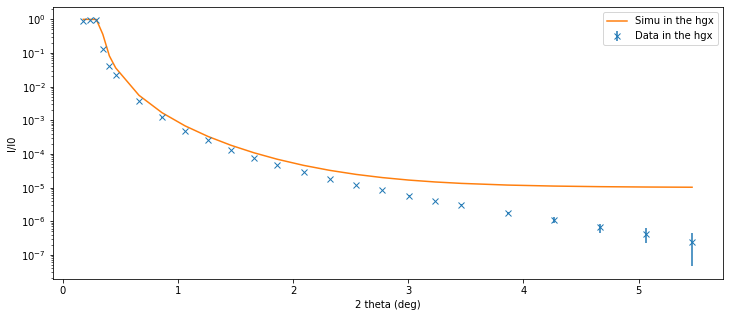

In [4]:
f = h5py.File("data/model_init.hgx", "r")

# data
x = f['current/data/datasets/0/x'][()]
y = f['current/data/datasets/0/y'][()]
error = f['current/data/datasets/0/error'][()]

# fit/simu curve contained in the hgx
y_sim = f['current/data/datasets/0/y_sim'][()]
f.close()

fig = plt.figure(figsize=(12,5))
plt.errorbar(x, y, yerr=error, fmt='x', label = 'Data in the hgx')
plt.plot(x, y_sim, label = 'Simu in the hgx')
plt.yscale('log')
plt.xlabel('2 theta (deg)')
plt.ylabel('I/I0')
plt.legend()
plt.show()

## Extract the fit parameters

We extract the simu/fit parameters from the group ```current/parameters```.

In [5]:
f = h5py.File("data/model_init.hgx", "r")

# Extract parameters
col0 = [val.decode("UTF-8") for val in f['current/parameters/data col 0'][()]]
col1 = [val for val in f['current/parameters/data col 1'][()]]
col2 = [val for val in f['current/parameters/data col 2'][()]]
col3 = [val for val in f['current/parameters/data col 3'][()]]
col4 = [val for val in f['current/parameters/data col 4'][()]]
col5 = [val for val in f['current/parameters/data col 5'][()]]
col_labels = [val.decode("UTF-8") for val in f['current/parameters/data_labels'][()]]
f.close()

# Reorganise as a table
tab0 = np.stack((col0, col1, col2, col3, col4, col5), axis = 1)
tab = np.vstack([col_labels, tab0])
for line in tab:
    if line[0] != '':
        print('%s\t%s\t%s\t%s\t%s\t%s'%(line[0], line[1], line[2], line[3], line[4], line[5]))

Parameter	Value	Fit	Min	Max	Error
Sub.setDens	0.04	True	0.025	0.041	-
Sub.setSigma	3.0	True	1.0	5.0	-
inst.setIbkg	1e-05	True	0.0	0.0001	-


# Running the fit

The results will be stored in the hgx ```results_A/result0.hgx```. Add ```-- debug``` for verbose.

In [6]:
!genx --run --mgen=100 data/model_init.hgx results_A/result0.hgx 

/bin/bash: genx: command not found


# Reading the results

We can extract the results from the hgx in a similar manner.

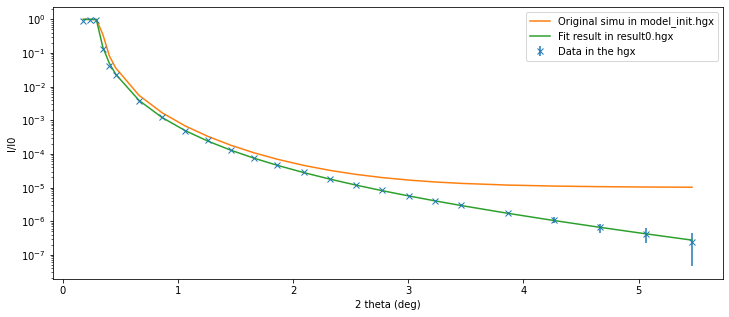

Fit results
----------
Parameter	Value
Sub.setDens	0.0343259
Sub.setSigma	2.44818
inst.setIbkg	1.28585e-15


In [7]:
f = h5py.File("results_A/result0.hgx", "r")

# data
x0 = f['current/data/datasets/0/x'][()]
y0 = f['current/data/datasets/0/y'][()]
error0 = f['current/data/datasets/0/error'][()]

# fit/simu curve contained in the hgx
y_sim0 = f['current/data/datasets/0/y_sim'][()]

fig = plt.figure(figsize=(12,5))
plt.errorbar(x0, y0, yerr=error0, fmt='x', label = 'Data in the hgx')
plt.plot(x, y_sim, label = 'Original simu in model_init.hgx')
plt.plot(x0, y_sim0, label = 'Fit result in result0.hgx')
plt.yscale('log')
plt.xlabel('2 theta (deg)')
plt.ylabel('I/I0')
plt.legend()
plt.show()

# Extract parameters
col0 = [val.decode("UTF-8") for val in f['current/parameters/data col 0'][()]]
col1 = [val for val in f['current/parameters/data col 1'][()]]
col2 = [val for val in f['current/parameters/data col 2'][()]]
col3 = [val for val in f['current/parameters/data col 3'][()]]
col4 = [val for val in f['current/parameters/data col 4'][()]]
col5 = [val for val in f['current/parameters/data col 5'][()]]
col_labels = [val.decode("UTF-8") for val in f['current/parameters/data_labels'][()]]
f.close()



# Reorganise as a table
tab0 = np.stack((col0, col1, col2, col3, col4, col5), axis = 1)
tab = np.vstack([col_labels, tab0])
print('Fit results')
print(10*'-')
for line in tab:
    if line[0] != '':
        try:
            print('%s\t%g'%(line[0], float(line[1])))
        except:
            print('%s\t%s'%(line[0], line[1]))

# Batch from the same initial model

We use the same initial hgx model and batch fit 3 scans.  
First we copy ```model_init.hgx``` to avoid overwriting it.

In [8]:
!cp data/model_init.hgx data/model_for_fit.hgx

## Generate the scans

For this example, we generate artificial scans from an original one (XRR liquid-air).

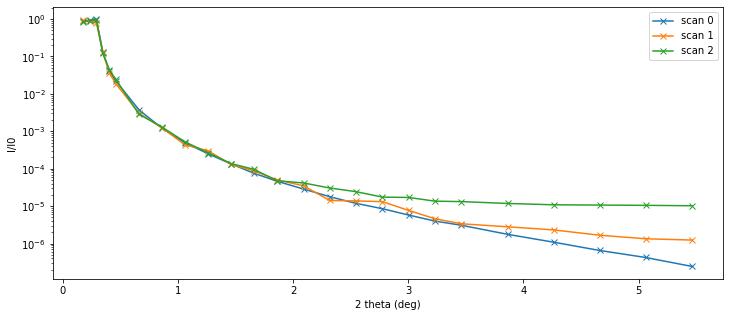

In [9]:
scan0 = np.genfromtxt('data/scan0.dat')
scan1 = scan0.copy()
scan2 = scan0.copy()

np.random.seed(28121987)
scan1[:,1] = scan0[:,1]*np.random.normal(1.,0.15,len(scan0))+1e-6
np.random.seed(27042021)
scan2[:,1] = scan0[:,1]*np.random.normal(1.,0.15,len(scan0))+1e-5

fig = plt.figure(figsize=(12,5))
plt.plot(scan0[:,0], scan0[:,1], 'x-', label = 'scan 0')
plt.plot(scan0[:,0], scan1[:,1], 'x-', label = 'scan 1')
plt.plot(scan0[:,0], scan2[:,1], 'x-', label = 'scan 2')
plt.yscale('log')
plt.xlabel('2 theta (deg)')
plt.ylabel('I/I0')
plt.legend()
plt.show()

np.savetxt('data/scan1.dat', scan1)
np.savetxt('data/scan2.dat', scan2)

## Batch

In [10]:
scans = [scan0, scan1, scan2]
for i, scan in enumerate(scans):
    f = h5py.File("data/model_for_fit.hgx", "a")
    f['current/data/datasets/0/x'][...] = scan[:,0]
    f['current/data/datasets/0/y'][...] = scan[:,1]
    f['current/data/datasets/0/error'][...] = scan[:,2]
    f.close()
    
    result_file = 'results_A/result'+str(i)+'.hgx'
    print(i, result_file)
    !genx --run --mgen=100 data/model_for_fit.hgx $result_file

0 results_A/result0.hgx
/bin/bash: genx: command not found
1 results_A/result1.hgx
/bin/bash: genx: command not found
2 results_A/result2.hgx
/bin/bash: genx: command not found


####################
Result 0


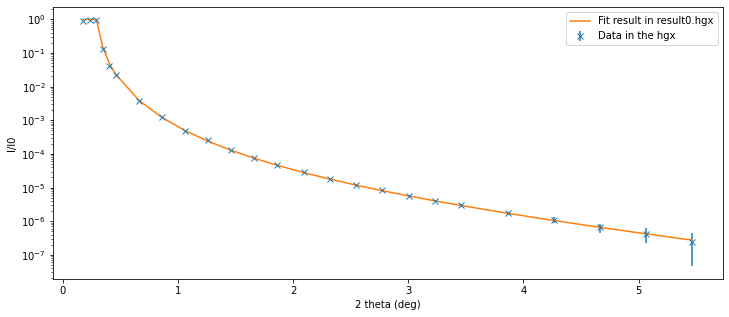

Fit results
----------
Parameter	Value
Sub.setDens	0.0343259
Sub.setSigma	2.44818
inst.setIbkg	1.28585e-15

####################
Result 1


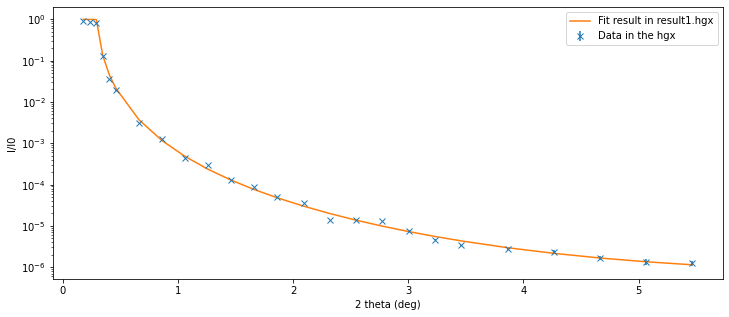

Fit results
----------
Parameter	Value
Sub.setDens	0.0333484
Sub.setSigma	1
inst.setIbkg	5.9602e-07

####################
Result 2


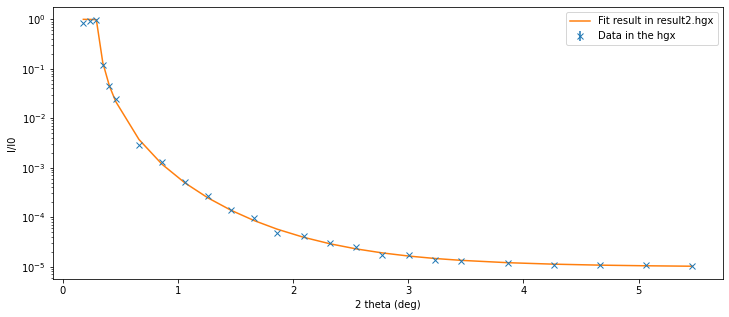

Fit results
----------
Parameter	Value
Sub.setDens	0.0333786
Sub.setSigma	1
inst.setIbkg	9.59845e-06



In [11]:
for i, _ in enumerate(scans):

    print(20*'#')
    print('Result %s'%str(i))
    f = h5py.File("results_A/result"+str(i)+".hgx", "r")

    # data
    x0 = f['current/data/datasets/0/x'][()]
    y0 = f['current/data/datasets/0/y'][()]
    error0 = f['current/data/datasets/0/error'][()]

    # fit/simu curve contained in the hgx
    y_sim0 = f['current/data/datasets/0/y_sim'][()]

    fig = plt.figure(figsize=(12,5))
    plt.errorbar(x0, y0, yerr=error0, fmt='x', label = 'Data in the hgx')
    plt.plot(x0, y_sim0, label = 'Fit result in result'+str(i)+'.hgx')
    plt.yscale('log')
    plt.xlabel('2 theta (deg)')
    plt.ylabel('I/I0')
    plt.legend()
    plt.show()

    # Extract parameters
    col0 = [val.decode("UTF-8") for val in f['current/parameters/data col 0'][()]]
    col1 = [val for val in f['current/parameters/data col 1'][()]]
    col2 = [val for val in f['current/parameters/data col 2'][()]]
    col3 = [val for val in f['current/parameters/data col 3'][()]]
    col4 = [val for val in f['current/parameters/data col 4'][()]]
    col5 = [val for val in f['current/parameters/data col 5'][()]]
    col_labels = [val.decode("UTF-8") for val in f['current/parameters/data_labels'][()]]
    f.close()

    # Reorganise as a table
    tab0 = np.stack((col0, col1, col2, col3, col4, col5), axis = 1)
    tab = np.vstack([col_labels, tab0])
    print('Fit results')
    print(10*'-')
    for line in tab:
        if line[0] != '':
            try:
                print('%s\t%g'%(line[0], float(line[1])))
            except:
                print('%s\t%s'%(line[0], line[1]))
                
    print('')

## Tune fit parameters, batch, and save

We also show how to adjust the fit parameters and then batch.

We disable the fit on the roughness, and adjust the upper bound on the electron density.

In [12]:
f = h5py.File("data/model_for_fit.hgx", "r")
# First check where the params are
col0 = [val.decode("UTF-8") for val in f['current/parameters/data col 0'][()]]
print(col0)
print('The electron density is at index %s'%str(col0.index("Sub.setDens")))
print('The roughness is at index %s'%str(col0.index("Sub.setSigma")))
print('')

col_labels = [val.decode("UTF-8") for val in f['current/parameters/data_labels'][()]]
print(col_labels)
print('The upper bound is in col %s'%str(col_labels.index("Max")))
print('The boolean for fitting is in col %s'%str(col_labels.index("Fit")))
print('')
f.close()

['', '', 'Sub.setDens', 'Sub.setSigma', 'inst.setIbkg']
The electron density is at index 2
The roughness is at index 3

['Parameter', 'Value', 'Fit', 'Min', 'Max', 'Error']
The upper bound is in col 4
The boolean for fitting is in col 2



In [13]:
f = h5py.File("data/model_for_fit.hgx", "a")

# Index of columns (always the same)
# 0: Parameter (string)
# 1: Value (float)
# 2: Fit (bool)
# 3: Min (float)
# 4: Max (float)
# 5: Error (float)

# Extract the parameter names
col0 = [val.decode("UTF-8") for val in f['current/parameters/data col 0'][()]]

############################################
# Change upper bound for electron density
# Find where the param is
arg_param = col0.index("Sub.setDens")
# Change its max value (needs to extract and update the whole array)
temp = f['current/parameters/data col 4'][()]
temp[arg_param] = 0.05
f['current/parameters/data col 4'][...] = temp

############################################
# Do not fit the roughness
# Find where the param is
arg_param = col0.index("Sub.setSigma")
# Change the boolean (needs to extract and update the whole array)
temp = f['current/parameters/data col 2'][()]
temp[arg_param] = False
f['current/parameters/data col 2'][...] = temp
f.close()


In [14]:
scans = [scan0, scan1, scan2]
for i, scan in enumerate(scans):
    f = h5py.File("data/model_for_fit.hgx", "a")
    f['current/data/datasets/0/x'][...] = scan[:,0]
    f['current/data/datasets/0/y'][...] = scan[:,1]
    f['current/data/datasets/0/error'][...] = scan[:,2]
    f.close()
    
    result_file = 'results_B/result'+str(i)+'.hgx'
    print(i, result_file)
    !genx --run --mgen=100 data/model_for_fit.hgx $result_file

0 results_B/result0.hgx
/bin/bash: genx: command not found
1 results_B/result1.hgx
/bin/bash: genx: command not found
2 results_B/result2.hgx
/bin/bash: genx: command not found


####################
Result 0


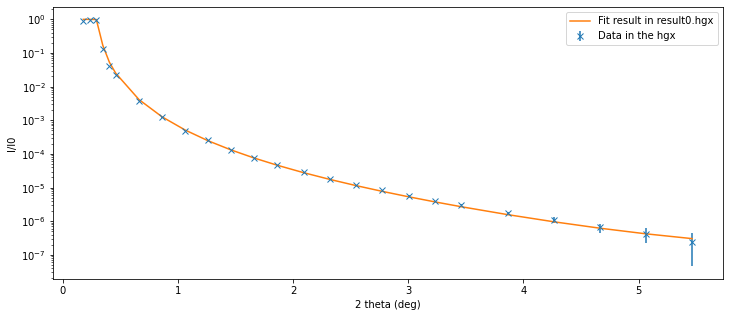

Fit results
----------
Parameter	Value
Sub.setDens	0.0352335
Sub.setSigma	3
inst.setIbkg	1.19794e-07

####################
Result 1


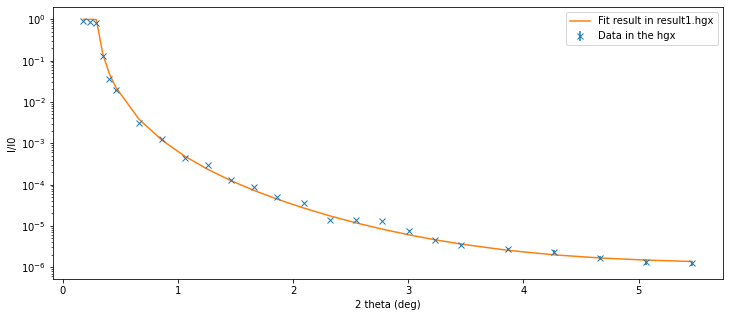

Fit results
----------
Parameter	Value
Sub.setDens	0.0340798
Sub.setSigma	3
inst.setIbkg	1.19866e-06

####################
Result 2


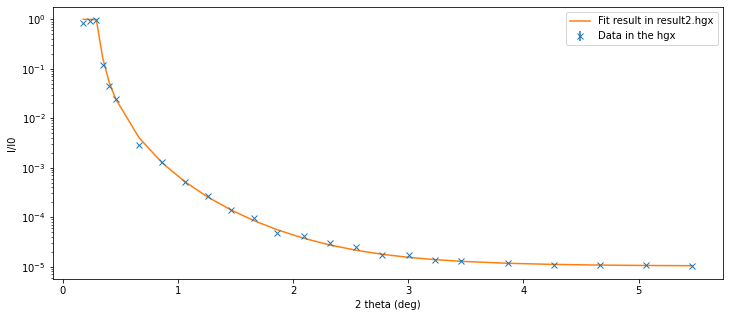

Fit results
----------
Parameter	Value
Sub.setDens	0.034939
Sub.setSigma	3
inst.setIbkg	1.02065e-05



In [15]:
is_first_loop = True

for i, _ in enumerate(scans):

    print(20*'#')
    print('Result %s'%str(i))
    f = h5py.File("results_B/result"+str(i)+".hgx", "r")

    # data
    x = f['current/data/datasets/0/x'][()]
    y = f['current/data/datasets/0/y'][()]
    error = f['current/data/datasets/0/error'][()]

    # fit/simu curve contained in the hgx
    y_sim = f['current/data/datasets/0/y_sim'][()]
    
    # Save the curves
    np.savetxt('results_B/fit'+str(i)+'.dat', np.transpose([x, y, y_sim, error]),
               header='#x\t#y\t#y_fit\t#error' )

    fig = plt.figure(figsize=(12,5))
    plt.errorbar(x, y, yerr=error, fmt='x', label = 'Data in the hgx')
    plt.plot(x, y_sim, label = 'Fit result in result'+str(i)+'.hgx')
    plt.yscale('log')
    plt.xlabel('2 theta (deg)')
    plt.ylabel('I/I0')
    plt.legend()
    plt.show()

    # Extract parameters
    col0 = [val.decode("UTF-8") for val in f['current/parameters/data col 0'][()]]
    col1 = [val for val in f['current/parameters/data col 1'][()]]
    col2 = [val for val in f['current/parameters/data col 2'][()]]
    col3 = [val for val in f['current/parameters/data col 3'][()]]
    col4 = [val for val in f['current/parameters/data col 4'][()]]
    col5 = [val for val in f['current/parameters/data col 5'][()]]
    col_labels = [val.decode("UTF-8") for val in f['current/parameters/data_labels'][()]]
    f.close()

    # Reorganise as a table
    tab0 = np.stack((col0, col1, col2, col3, col4, col5), axis = 1)
    tab = np.vstack([col_labels, tab0])
    print('Fit results')
    print(10*'-')
    for line in tab:
        if line[0] != '':
            try:
                print('%s\t%g'%(line[0], float(line[1])))
            except:
                print('%s\t%s'%(line[0], line[1]))
                
    print('')
    
    # Save the parameters
    
    if is_first_loop:
        # Write the header
        
        # Get rid of the empty lines in the parameter list
        pos_arg = np.array([True if val != '' else False for val in col0])
        
        # Mask the arrays to keep only the non-empty lines
        col0 = np.array(col0)[pos_arg]
        
        with open('results_B/summary.dat', 'w') as file:
            file.write('#index_fit\t')
            for item in col0:
                file.write('#%s\t'%item)
            file.write('\n')
        
        
        is_first_loop = False
    
    # Mask the arrays to keep only the non-empty lines
    col1 = np.array(col1)[pos_arg]
    with open('results_B/summary.dat', 'a') as file:
        file.write('%s\t'%str(i))
        for item in col1:
            file.write('%g\t'%item)
        file.write('\n')
    
    
   